In [32]:
import os
from dotenv import load_dotenv

In [33]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph, END
from langchain_milvus import Milvus
from typing_extensions import List, TypedDict, Optional
from langchain_core.documents import Document
from pydantic import BaseModel, Field
import logging
from langchain_core.tools import BaseTool
import json 
import uuid

# Load environment variables from .env file
load_dotenv()
# Set up logging in a file
logger = logging.getLogger(__name__)
logging.basicConfig(
    filename='rag_gd.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [34]:
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "manuals"

In [35]:
milvus_uri = f"http://{MILVUS_HOST}:{MILVUS_PORT}"
connection_args = {"uri": milvus_uri}

In [36]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [37]:
prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
    Você é um assistente especialista em responder perguntas sobre manuais automotivos.  
    – Use apenas o conteúdo fornecido no contexto. Se a resposta não estiver lá, diga “Não sei, não tenho essa informação”.
    – Responda em **no máximo cinco frases**, sendo conciso e preciso.  
    – **Sempre indique a localização exata** de qualquer componente ou controle mencionado, caso aplicável.
    – Dê instruções claras, passo a passo, quando aplicável.
    - Não mencione o número da página.
    - Evite responder mais do que o necessário.
    - Não faça suposições ou adivinhações.

    Pergunta: {question}
    Contexto: {context}
    Resposta:
    """)
])

In [38]:
vectorstore = Milvus(
    collection_name="manuals",
    embedding_function=embeddings,
    connection_args=connection_args,
    auto_id=True,
    consistency_level="Strong",
    search_params={"metric_type": "L2", "params": {"nprobe": 10}}
)

In [39]:
class State(TypedDict):
    question: str
    original_question: str
    context: List[Document]
    answer: str
    brand: Optional[str]
    model: Optional[str]
    year: Optional[str]

    # Campos para avaliação da resposta
    answer_binary_score: Optional[str]
    answer_utility_score: Optional[str]
    
    # Flag para controlar a reescrita única
    has_rewritten_question: bool 

In [87]:
class GradeAnswerInput(BaseModel):
    question: str
    generation: str
    
class GradeAnswer(BaseModel):
    binary_score: str = Field(
        description="Token que indica se a resposta resolve a pergunta: 'sim' ou 'não'."
    )
    utility_score: str = Field(
        description=(
            "Token que indica o nível de utilidade da resposta:\n"
            "- 'Utility:5': Resposta excelente, completa e satisfatória.\n"
            "- 'Utility:4': Resposta boa, mas poderia ser mais completa.\n"
            "- 'Utility:3': Resposta parcialmente útil, mas com lacunas claras.\n"
            "- 'Utility:2': Resposta bastante limitada, imprecisa ou incompleta.\n"
            "- 'Utility:1': Resposta de baixa qualidade, sem utilidade ou incorreta."
        )
    )

class AnswerGraderTool(BaseTool):
    """
    Tool that evaluates if a generated answer resolves the user's question and its utility level.
    
    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of what the tool does.
    """
    name: str = "AnswerGrader"
    description: str = "Avalia se uma resposta gerada resolve a pergunta do usuário e qual o nível de utilidade."

    def _run(self, input_data: GradeAnswerInput) -> GradeAnswer:
        logger.info("NODE_TOOL: Executando AnswerGraderTool...")
        logger.debug(f"Input para AnswerGraderTool: {input_data}")
    
        binary_score = "não" 
        utility_score = "Utility:1"

        grader_llm = llm # Usando o LLM global

        system_prompt_grader = """
        Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
        Sua tarefa é avaliar e fornecer dois tokens:
        1. Uma resposta binária: 'sim', se a resposta resolve a pergunta, ou 'não', caso contrário.
        2. Uma avaliação do nível de utilidade da resposta em uma escala de 'Utility:1' a 'Utility:5', onde:
           - 'Utility:5': Resposta excelente, completa e satisfatória.
           - 'Utility:4': Resposta boa, mas poderia ser mais completa.
           - 'Utility:3': Resposta parcialmente útil, mas com lacunas claras.
           - 'Utility:2': Resposta bastante limitada, imprecisa ou incompleta.
           - 'Utility:1': Resposta de baixa qualidade, sem utilidade ou incorreta.
        
        Responda no seguinte formato exato, em duas linhas separadas:
        [sim/não]
        Utility:[1-5]
        """
        prompt_messages = [
            ("system", system_prompt_grader),
            ("human", f"Pergunta do Usuário: {input_data.question}\n\nResposta Gerada: {input_data.generation}\n\nAvalie a resposta.")
        ]
        
        try:
            response = grader_llm.invoke(prompt_messages)
            response_content = getattr(response, "content", "").strip()
            logger.debug(f"Resposta do LLM Grader: {response_content}")

            lines = response_content.split('\n')
            if len(lines) >= 1: # Checa pelo menos a primeira linha
                potential_binary_score = lines[0].strip().lower()
                if potential_binary_score in ["sim", "não"]:
                    binary_score = potential_binary_score
            
            if len(lines) >= 2: # Checa a segunda linha
                potential_utility_score = lines[1].strip()
                if potential_utility_score.startswith("Utility:") and \
                   potential_utility_score.split(":")[1].isdigit() and \
                   1 <= int(potential_utility_score.split(":")[1]) <= 5:
                    utility_score = potential_utility_score
                else:
                    logger.warning(f"Formato do Utility Score inesperado: {potential_utility_score}")
            else:
                logger.warning(f"Resposta do LLM Grader não continha linha de Utility Score: {response_content}")


        except Exception as e:
            logger.error(f"Erro durante a avaliação da resposta pela AnswerGraderTool: {e}", exc_info=True)

        logger.info(f"Avaliação da resposta (AnswerGraderTool): Binário='{binary_score}', Utilidade='{utility_score}'")
        return GradeAnswer(binary_score=binary_score, utility_score=utility_score)

class FeedbackGuidedQuestionRewriteInput(BaseModel):
    """
    Class to hold input data for the question optimization tool.
    
    Attributes:
        current_question (str): The current question from the user.
        previous_generation (str): The previous answer generated by the system.
        previous_utility_score (str): The utility score of the previous answer.
        previous_binary_score (str): The binary score indicating if the previous answer resolved the question.
        iterations (int): Number of iterations for optimization, default is 1.
    """
    current_question: str
    previous_generation: str
    previous_utility_score: str
    previous_binary_score: str
    iterations: int = 1

class GradientDescentQuestionOptimizer(BaseTool):
    """
    Tool that optimizes the user's question based on feedback from a previous answer.
    
    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of what the tool does.
    """
    name: str = "GradientDescentQuestionOptimizer"
    description: str = "Otimiza a pergunta do usuário com base no feedback de uma resposta anterior."
    # Usará o LLM global com ajuste de temperatura.

    def _run(self, input_data: FeedbackGuidedQuestionRewriteInput) -> str:
        current_question = input_data.current_question
        previous_generation = input_data.previous_generation
        utility_score = input_data.previous_utility_score
        
        # Pode usar o LLM global, mas com uma temperatura diferente para criatividade
        rewriter_llm = ChatOpenAI(model=llm.model_name, temperature=0.3) 

        logger.info(f"NODE_TOOL: Iniciando Otimização de Pergunta para: '{current_question}'")
        logger.info(f"Geração anterior teve utilidade: {utility_score}")
        
        optimized_question = current_question 

        for i in range(input_data.iterations): # Normalmente será 1 neste fluxo
            logger.info(f"--- Iteração de Otimização de Pergunta {i + 1} (de {input_data.iterations})---")

            analysis_prompt_text = f"""
            A seguinte pergunta de usuário foi feita a um sistema de Q&A sobre manuais automotivos:
            "{current_question}"

            A resposta gerada pelo sistema foi:
            "{previous_generation}"

            Esta resposta foi avaliada com uma utilidade de: "{utility_score}".

            Forneça até três razões concisas pelas quais a pergunta original pode ter levado a uma resposta com esta avaliação de utilidade.
            Concentre-se em como a pergunta poderia ser melhorada para obter informações mais precisas e úteis de um manual automotivo.
            Exemplos de razões: "A pergunta era muito genérica", "Faltou especificar o tipo de combustível", "O termo usado não é comum em manuais".
            Envolva cada razão com <START_REASON> e <END_REASON>.
            """
            reasons = ["A pergunta pode precisar ser mais clara ou específica para o contexto do manual."] # Fallback
            try:
                logger.info("Analisando razões para baixa utilidade (gerando 'gradientes').")
                analysis_response = rewriter_llm.invoke(analysis_prompt_text)
                analysis_content = getattr(analysis_response, "content", "").strip()
                extracted_reasons = [
                    r.split("<END_REASON>")[0].strip() 
                    for r in analysis_content.split("<START_REASON>")[1:] if "<END_REASON>" in r
                ]
                if extracted_reasons:
                    reasons = extracted_reasons
                logger.info(f"Razões extraídas (gradientes): {reasons}")
            except Exception as e:
                logger.error(f"Erro ao gerar razões/gradientes: {e}", exc_info=True)

            rewrite_prompt_text = f"""
            A pergunta original do usuário foi: "{current_question}"
            Ela levou a uma resposta com utilidade "{utility_score}".
            A análise sugere que isso pode ter ocorrido devido a:
            {'- ' + '\n- '.join(reasons)}

            Proponha uma versão revisada e otimizada da pergunta do usuário. NÃO há necessidade de especificar o modelo, marca ou ano do veículo na pergunta.
            A nova pergunta deve:
            - Ser mais clara e específica.
            - Usar terminologia apropriada para manuais automotivos.
            - Ser formulada para maximizar a chance de obter uma resposta altamente útil e precisa do sistema.
            - Se a pergunta original parecia buscar uma informação que não foi encontrada, tente reformular para abordar o mesmo objetivo de informação de uma maneira diferente.

            Retorne APENAS a pergunta revisada, sem nenhum outro texto ou explicação.
            """
            try:
                logger.info("Reescrevendo a pergunta com base na análise.")
                rewrite_response = rewriter_llm.invoke(rewrite_prompt_text)
                new_question_candidate = getattr(rewrite_response, "content", "").strip().replace("Pergunta Revisada:", "").replace("Nova Pergunta:", "").strip()


                if new_question_candidate and new_question_candidate.lower() != optimized_question.lower():
                    optimized_question = new_question_candidate
                    logger.info(f"Pergunta atualizada na iteração {i + 1}: '{optimized_question}'")
                else:
                    logger.info(f"Reescrita não produziu uma nova pergunta diferente na iteração {i + 1} ou foi vazia. Mantendo: '{optimized_question}'")
                    if i > 0: break 
            except Exception as e:
                logger.error(f"Erro ao aplicar razões/gradientes para reescrever pergunta: {e}", exc_info=True)
                break 
        
        logger.info(f"Otimização completa. Pergunta final otimizada: '{optimized_question}'")
        return optimized_question

# Instâncias das ferramentas
answer_grader = AnswerGraderTool()
question_optimizer = GradientDescentQuestionOptimizer()

In [88]:
# --- Funções de Nó para o Grafo ---
def retrieve_node(state: State) -> State:
    """
    Retrieves relevant documents from the vector store based on the current question.
    
    Args:
        state (State): The current state containing the question and other parameters.
        
    Returns:
        State: The updated state with retrieved documents in the context.
    """
    logger.info(f"NODE: retrieve_node - Pergunta Atual: '{state['question']}'")
    question = state["question"]
    
    if "original_question" not in state or not state["original_question"]:
        state["original_question"] = question
        logger.info(f"Pergunta original definida como: '{state['original_question']}'")


    brand = state.get("brand")
    model = state.get("model")
    year = state.get("year")

    filter_conditions = []
    if brand: filter_conditions.append(f'brand == "{brand}"')
    if model: filter_conditions.append(f'model == "{model}"')
    if year: filter_conditions.append(f'year == "{str(year)}"')

    filter_expr = " and ".join(filter_conditions) if filter_conditions else None
    logger.info(f"Filtro para retriever: {filter_expr if filter_expr else 'Nenhum'}")

    # search_params definidos na instância do vectorstore
    if filter_expr:
        retrieved_docs = vectorstore.similarity_search(query=question, k=10, expr=filter_expr)
    else:
        retrieved_docs = vectorstore.similarity_search(query=question, k=10)
    
    logger.info(f"Recuperados {len(retrieved_docs)} documentos.")
    # Limpa a resposta anterior antes de uma nova geração, se houver
    state["answer"] = "" 
    state["context"] = retrieved_docs
    return state

def generate_node(state: State) -> State:
    """
    Generates an answer based on the retrieved context and the current question.
    
    Args:
        state (State): The current state containing the question and context documents.
        
    Returns:
        State: The updated state with the generated answer.
    """
    logger.info(f"NODE: generate_node - Pergunta: '{state['question']}'")
    question = state["question"]
    context_docs = state["context"]

    if not context_docs:
        logger.warning("Nenhum contexto recuperado para generate_node. A resposta será 'Não sei'.")
        state["answer"] = "Não sei, não tenho essa informação nos documentos fornecidos."
        return state

    docs_content = "\n\n".join(doc.page_content for doc in context_docs)
    
    messages = prompt.invoke({"question": question, "context": docs_content})
    response = llm.invoke(messages)
    
    answer = getattr(response, "content", str(response))
    logger.info(f"Resposta gerada: {answer[:300]}...") # Aumentado o log da resposta
    state["answer"] = answer
    return state

def grade_answer_node(state: State) -> State:
    """
    Grades the generated answer to determine if it resolves the question and its utility level.
    
    Args:
        state (State): The current state containing the question and generated answer.
        
    Returns:
        State: The updated state with the binary score and utility score of the answer.
    """
    logger.info("NODE: grade_answer_node")
    question_to_evaluate = state.get("original_question", state["question"]) 
    generation = state.get("answer", "")

    if not generation or generation.strip() == "Não sei, não tenho essa informação nos documentos fornecidos.": # Também trata resposta padrão
        logger.warning(f"Nenhuma resposta útil gerada para avaliar: '{generation}'")
        state["answer_binary_score"] = "não"
        state["answer_utility_score"] = "Utility:1" # Score de falha se "Não sei"
        return state

    grade_input = GradeAnswerInput(question=question_to_evaluate, generation=generation)
    grade_result = answer_grader._run(grade_input)
    
    state["answer_binary_score"] = grade_result.binary_score
    state["answer_utility_score"] = grade_result.utility_score
    logger.info(f"Avaliação da resposta (vs original '{question_to_evaluate}'): Binário='{grade_result.binary_score}', Utilidade='{grade_result.utility_score}'")
    return state

def rewrite_question_node(state: State) -> State:
    """
    Rewrites the user's question based on feedback from the previous answer.
    
    Args:
        state (State): The current state containing the question and previous answer.
        
    Returns:
        State: The updated state with the optimized question."""
    logger.info("NODE: rewrite_question_node")
    
    rewrite_input_data = FeedbackGuidedQuestionRewriteInput(
        current_question=state["question"], # A pergunta que levou à resposta ruim
        previous_generation=state.get("answer", "N/A"),
        previous_utility_score=state.get("answer_utility_score", "Utility:0"),
        previous_binary_score=state.get("answer_binary_score", "não"),
        iterations=1 
    )
    try:
        optimized_question = question_optimizer._run(rewrite_input_data)
        if optimized_question and optimized_question.strip() and \
           optimized_question.strip().lower() != state["question"].strip().lower():
            logger.info(f"Pergunta anterior: '{state['question']}'")
            logger.info(f"Pergunta OTIMIZADA para: '{optimized_question}'")
            state["question"] = optimized_question 
        else:
            logger.warning(f"Otimizador não retornou uma pergunta nova/diferente ou retornou vazia. Mantendo: '{state['question']}'")
            # Se a pergunta não mudar, a flag has_rewritten_question ainda será setada,
            # e o loop não continuará na próxima vez (para o caso de uma única reescrita).
    except Exception as e:
        logger.error(f"Erro ao reescrever a pergunta com feedback: {e}", exc_info=True)
        logger.info(f"Falha na tentativa de reescrita. Mantendo pergunta anterior.")
    return state

def mark_as_rewritten_node(state: State) -> State:
    """
    Marks the state to indicate that the question has been rewritten.
    
    Args:
        state (State): The current state to be updated.
        
    Returns:
        State: The updated state with the flag indicating the question has been rewritten.
    """
    logger.info("NODE: mark_as_rewritten_node - Marcando que a pergunta foi reescrita.")
    state['has_rewritten_question'] = True
    return state

# --- Função Condicional ---
MIN_ACCEPTABLE_UTILITY_SCORE = 4 # Defina seu limiar de qualidade aqui

def decide_after_first_answer(state: State) -> str:
    """
    Decides the next step after the first answer based on the binary score and utility score.
    
    Args:
        state (State): The current state containing the binary score and utility score.
        
    Returns:
        str: The next step to take in the process.
    """
    logger.info("CONDITIONAL: decide_after_first_answer")
    binary_score = state.get("answer_binary_score")
    utility_score_str = state.get("answer_utility_score")
    has_rewritten = state.get("has_rewritten_question", False)

    current_utility = 0
    if utility_score_str and "Utility:" in utility_score_str:
        try:
            current_utility = int(utility_score_str.split(":")[1])
        except (ValueError, IndexError, TypeError): # Adicionado TypeError
            logger.warning(f"Não foi possível parsear utility_score: '{utility_score_str}'. Assumindo utilidade 0.")
            current_utility = 0
    
    if binary_score == "sim" and current_utility >= MIN_ACCEPTABLE_UTILITY_SCORE:
        logger.info(f"Resposta satisfatória (Binário: {binary_score}, Utilidade: {current_utility}). Finalizando.")
        return "end_process_success"
    elif not has_rewritten: 
        logger.info(f"Primeira resposta NÃO satisfatória (Binário: {binary_score}, Utilidade: {current_utility}). Tentando reescrever a pergunta.")
        return "rewrite_question"
    else: 
        logger.info(f"Resposta NÃO satisfatória (Binário: {binary_score}, Utilidade: {current_utility}) APÓS UMA TENTATIVA de reescrita. Finalizando.")
        return "end_process_after_rewrite_fail"

In [89]:
# --- Montando o Grafo com Estrutura Cíclica (para uma reescrita) ---
graph_builder = StateGraph(State)

# Adiciona os nós (usando nomes genéricos que serão reutilizados no ciclo)
graph_builder.add_node("retrieve_step", retrieve_node)
graph_builder.add_node("generate_step", generate_node)
graph_builder.add_node("grade_answer_step", grade_answer_node)
graph_builder.add_node("rewrite_question_step", rewrite_question_node)
graph_builder.add_node("mark_rewritten_step", mark_as_rewritten_node)

# Ponto de entrada
graph_builder.set_entry_point("retrieve_step")

# Fluxo principal
graph_builder.add_edge("retrieve_step", "generate_step")
graph_builder.add_edge("generate_step", "grade_answer_step")

# Lógica condicional após a avaliação da resposta
# A função decide_after_first_answer retorna:
# - "end_process_success" (se a resposta for boa)
# - "rewrite_question" (se a resposta for ruim e ainda não reescreveu)
# - "end_process_after_rewrite_fail" (se a resposta for ruim e JÁ reescreveu)
graph_builder.add_conditional_edges(
    "grade_answer_step",
    decide_after_first_answer,
    {
        "rewrite_question": "rewrite_question_step",
        "end_process_success": END, 
        "end_process_after_rewrite_fail": END 
    }
)

# Fluxo de reescrita e volta ao início do ciclo
graph_builder.add_edge("rewrite_question_step", "mark_rewritten_step")
graph_builder.add_edge("mark_rewritten_step", "retrieve_step") # <<-- VOLTA PARA O INÍCIO DO CICLO

# Compila o grafo
graph = graph_builder.compile()

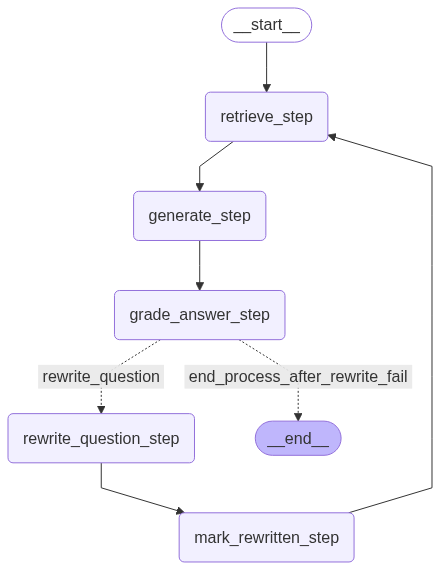

In [90]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [73]:
def save_response_json(resposta_final: dict, filename: str = "resultados_rag_vw.json", modelo_rag: str = "rag"):
    """
    Gets the final response from the RAG process and saves it to a JSON file.
    
    Args:
        resposta_final (dict): The final response dictionary containing the question, context, and answer.
        filename (str): The name of the JSON file to save the results. Defaults to 'resultados_rag.json'.
        
    Returns:
        None: The function saves the response to a JSON file and does not return anything.
    """
    
    # Pega a pergunta original que foi salva no início do processo.
    # Se 'original_question' não existir, usa 'question' como fallback.
    pergunta_original_usuario = resposta_final.get("original_question", resposta_final["question"])

    # Verifica se a pergunta foi reescrita para salvar essa informação também.
    pergunta_reescrita = "N/A"
    if resposta_final.get("has_rewritten_question", False):
        pergunta_reescrita = resposta_final["question"] # A chave 'question' terá a versão reescrita

    resultado = {
        "id_pergunta": f"P_{str(uuid.uuid4())[:8]}",
        "pergunta_usuario": pergunta_original_usuario,  # <--- AQUI ESTÁ A MUDANÇA PRINCIPAL
        "pergunta_reescrita_pelo_sistema": pergunta_reescrita, # <--- BÔNUS: ótimo para log
        "contexto_recuperado": "\n\n".join(doc.page_content for doc in resposta_final["context"]),
        "resposta_gerada": resposta_final["answer"],
        "modelo_rag": modelo_rag,
        "metadados": {
            "marca": resposta_final.get("brand"),
            "modelo": resposta_final.get("model"),
            "ano": resposta_final.get("year")
        }
    }

    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lista_resultados = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        lista_resultados = []
        
    lista_resultados.append(resultado)
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(lista_resultados, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Resposta salva com sucesso em '{filename}'")
    print(f"   - Pergunta Original Salva: '{pergunta_original_usuario}'")
    if pergunta_reescrita != "N/A":
        print(f"   - Pergunta Reescrita: '{pergunta_reescrita}'")


## **Questions** 

### **Volkswagen**

In [74]:
question = [
    "Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?", # 1
    "Como eu conecto meu celular Android no carro para usar os aplicativos na tela?", # 2
    "Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?", # 3
    "A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?", # 4
    "Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?", # 5
    "Como eu ajusto a hora no painel do carro?", # 6
    "Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?", # 7
    "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?", # 8
    "Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?", # 9
    "Quando é a próxima revisão do carro? É por tempo ou por quilometragem?" # 10
]

### 1 - Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?

In [75]:
response = graph.invoke({"question": question[0], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
      

In [76]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
A luz amarela do motor acesa indica que a unidade de controle do motor está avariada e o motor deve ser verificado imediatamente por uma Concessionária Volkswagen. Se a luz estiver acesa devido a uma deficiência de emissões do sistema de escape, é recomendado diminuir a velocidade e conduzir com cuidado até a concessionária mais próxima. Caso a luz pisque, isso indica um catalisador avariado, e você deve também diminuir a velocidade e procurar a concessionária. É importante não ignorar essas luzes, pois podem causar danos ao veículo. Se necessário, verifique o display do instrumento combinado para mensagens adicionais sobre o estado do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?'
   - Pergunta Reescrita: '"O que significa a luz amarela do motor acesa no paine

### 2 - Como eu conecto meu celular Android no carro para usar os aplicativos na tela?

In [77]:
response = graph.invoke({"question": question[1], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:writes] Finished step 1 with writes to 7 channels:
- question -> 'Como eu cone

In [78]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Para conectar seu smartphone Android ao sistema de infotainment do carro usando o Android Auto™, siga estas etapas: 

1. Verifique se seu telefone suporta o Android Auto™ e se você tem o aplicativo adequado instalado, se necessário.
2. Conecte o telefone ao rádio usando um cabo USB original do fabricante do telefone.
3. Quando conectar pela primeira vez, siga as instruções exibidas no display do rádio e no telefone.
4. Pressione o botão do rádio para acessar as funções do Android Auto™.
5. Selecione seu telefone móvel pressionando o ícone correspondente no menu App-Connect.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
   - Pergunta Reescrita: 'Como posso conectar meu smartphone Android ao sistema de infotainment do meu carro para acessar e utilizar aplicativos na tela do veículo?'


### 3 - Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?

In [79]:
response = graph.invoke({"question": question[2], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}

In [80]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
A pressão ideal dos pneus para o seu veículo pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta indica a pressão dos pneus para os eixos dianteiro e traseiro, além de orientações para diferentes condições de carga. É importante verificar a pressão dos pneus quando eles estiverem frios, ou seja, após não terem rodado mais que alguns quilômetros. Recomenda-se verificar a pressão pelo menos a cada 15 dias e antes de viagens longas. Se necessário, ajuste a pressão de acordo com as informações da etiqueta.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'
   - Pergunta Reescrita: 'Qual é a pressão ideal dos pneus para o meu veículo durante o uso diário e onde posso encontrar essa informação no manual do proprietário?'


### 4 - A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?

In [81]:
response = graph.invoke({"question": question[3], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'ye

In [82]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
A luz de advertência do freio acesa em vermelho, juntamente com um sinal sonoro ativo, indica um problema sério no sistema de freios do veículo. É fundamental não ignorar essa luz e parar o veículo assim que possível em um local seguro, garantindo a segurança de todos os passageiros e demais condutores. Estacione o veículo a uma distância segura da pista de rodagem, evitando que peças do sistema de escape entrem em contato com materiais inflamáveis. Não é seguro continuar dirigindo até que o problema seja verificado e corrigido.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'
   - Pergunta Reescrita: '"O que significa a luz de advertência do freio acesa em vermelho e o sinal sonoro ativo no painel do meu veículo? É seguro continuar dirigindo?"'


### 5 - Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?

In [83]:
response = graph.invoke({"question": question[4], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[1:tasks] Starting 1 ta

In [84]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
O sistema Start-Stop desliga automaticamente o motor ao parar o veículo e o liga novamente ao retirar o pé do freio ou pisar no acelerador. É recomendável desativar o sistema manualmente em situações como travessias de trechos alagados, para evitar danos à bateria ou problemas de funcionamento. Para desativar, consulte as orientações no display do instrumento combinado. Além disso, evite deixar a ignição ligada por longos períodos com o motor desligado, pois isso pode descarregar a bateria. Sempre desligue a ignição manualmente ao sair do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'
   - Pergunta Reescrita: '"Como funciona o sistema de parada e partida automática do motor no meu carro e em quais situações é recomendável

### 6 - Como eu ajusto a hora no painel do carro?

In [92]:
response = graph.invoke({"question": question[5], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:writes] Finished step 1 with writes to 7 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- original_question -> 'Como eu ajusto a hora no painel do carro?'
- answer -> ''
- context -> [Document(m

In [93]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Para ajustar a hora no relógio do painel do seu carro, siga um dos métodos abaixo:

1. **Através do rádio**: Pressione o botão do rádio, toque na superfície de função para abrir o menu Configurações do veículo, e selecione Hora e data para ajustar o horário.
   
2. **Através do instrumento combinado digital**: No menu Dados de viagem, selecione o indicador Autonomia, mantenha pressionado o botão OK no volante por cerca de cinco segundos, selecione o menu Hora e ajuste o relógio com os botões de seta.

3. **Através do instrumento combinado analógico**: Ligue a ignição, pressione o botão no instrumento combinado para selecionar o indicador das horas, ajuste as horas e minutos pressionando brevemente o botão correspondente e finalize pressionando novamente o botão.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Como eu ajusto a hora no painel do carro?'
   - Pergunta Reescrita: 'Como posso a

### 7 - Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?

In [94]:
response = graph.invoke({"question": question[6], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:writes] Finished step 1 

In [95]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
O macaco e as ferramentas necessárias para trocar um pneu furado estão localizados no compartimento de bagagem do veículo. Para realizar a troca, siga estes passos: 

1. Estacione o veículo em um local seguro e firme, ligue as luzes de advertência e use o triângulo de segurança.
2. Solte os parafusos da roda a ser trocada, utilizando a chave de roda, mas não os remova completamente.
3. Localize o ponto de apoio do macaco sob o veículo, próximo à roda a ser trocada, e posicione o macaco corretamente.
4. Levante o veículo até que a roda fique suspensa e, em seguida, remova os parafusos e a roda danificada.
5. Instale a roda de emergência, aperte os parafusos firmemente e abaixe o veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'
   - Pergunta Reescrita: 'Onde posso encontrar o macaco e as ferra

### 8 - O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?

In [96]:
response = graph.invoke({"question": question[7], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a 

In [97]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
O modo 'Eco' prioriza a economia de combustível, com a marcha sendo comutada automaticamente para a função de roda-livre. Já o modo 'Sport' proporciona uma condução mais esportiva, alterando o som do motor e mudando a alavanca seletora para a posição S. Para alternar entre os modos, leve a alavanca seletora para trás para mudar de D para S. Essa troca pode ser feita com o veículo parado ou em movimento, mas é recomendado tirar rapidamente o pé do acelerador para ativar o novo perfil de condução no motor.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?'
   - Pergunta Reescrita: 'Quais são as principais diferenças entre os modos de condução 'Eco' e 'Sport' em um veículo, e como posso alternar entre esses modos?'


### 9 - Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?

In [98]:
response = graph.invoke({"question": question[8], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial n

In [99]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Não sei, não tenho essa informação.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'
   - Pergunta Reescrita: 'Quais são as especificações de capacidade de reboque e recomendações do manual para o meu veículo ao utilizar um reboque pequeno?'


### 10 - Quando é a próxima revisão do carro? É por tempo ou por quilometragem?

In [100]:
response = graph.invoke({"question": question[9], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:writes] Finished step 1 with writes to 7 channels:
- question -> 'Quando é a próxima revisão do carro? É por t

In [101]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_vw.json", modelo_rag="rag_gd")


--- Resposta gerada ---
O intervalo recomendado para a próxima revisão do veículo, em condições normais, é a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro. Em condições adversas, o intervalo é de 10.000 km ou 6 meses, também prevalecendo o que ocorrer primeiro. É importante seguir rigorosamente esses prazos para evitar a perda de garantia do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_vw.json'
   - Pergunta Original Salva: 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
   - Pergunta Reescrita: 'Qual é o intervalo recomendado para a próxima revisão do veículo em termos de tempo e quilometragem?'


### **Fiat**

In [102]:
question = [
    "Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?", # 1
    "A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?", # 2
    "Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?", # 3
    "A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?", # 4
    "Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?", # 5
    "As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?", # 6
    "Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?", # 7
    "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?", # 8
    "Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?", # 9
    "Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?" # 10
]

### 1- Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?

In [103]:
response = graph.invoke({"question": question[0], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'A

In [104]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
O estepe, o macaco e as ferramentas necessárias para trocar um pneu estão localizados no porta-ferramentas B, sob a roda sobressalente. O triângulo de segurança está no porta-malas, próximo ao sistema de travamento da tampa. Para trocar o pneu, siga estes passos: 

1. Estacione o veículo em um local seguro, longe da borda da pista, e ligue as luzes de emergência.
2. Alivie os parafusos da roda furada com a chave de roda, enquanto a roda ainda estiver no chão.
3. Coloque calços na roda oposta e levante o veículo com o macaco.
4. Remova a roda furada, instale a roda sobressalente e aperte os parafusos sem apertá-los totalmente.
5. Baixe o veículo e, em seguida, aperte os parafusos completamente.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'
  

### 2 - A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?

In [105]:
response = graph.invoke({"question": question[1], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand'

In [106]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Para realizar a partida do seu veículo utilizando um cabo de chupeta, siga estes passos: 

1. Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.
2. Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.
3. Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.
4. Conecte a outra extremidade do cabo negativo (-) a um ponto de massa do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.
5. Ligue o motor do veículo com a bateria auxiliar e, após alguns minutos, ligue o motor do veículo com a bateria descarregada. 

Certifique-se de que todos os acessórios elétricos estejam desligados antes de iniciar o procedimento.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'A bateria parece ter descarregado e o c

### 3 - Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?

In [107]:
response = graph.invoke({"question": question[2], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:writes] Finished step 1 with wri

In [108]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
A pressão recomendada para os pneus do seu veículo pode ser encontrada no capítulo "Dados técnicos" do manual do proprietário. É importante verificar regularmente a pressão dos pneus, incluindo o pneu sobressalente, e calibrá-los conforme os valores indicados nesse capítulo. Para realizar a calibração, verifique a pressão a frio e, se necessário, ajuste-a conforme as recomendações. Após o enchimento, não esqueça de realizar o reset do sistema de monitoramento da pressão dos pneus, conforme descrito no capítulo "Sistema de monitoramento da pressão dos pneus".

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'
   - Pergunta Reescrita: 'Qual é a pressão recomendada para os pneus do meu veículo e onde posso localizar essa informação no manual do proprietário?'


### 4 - A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?

In [109]:
response = graph.invoke({"question": question[3], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:writes] Finished step 1 with writes to 7 channels:
- question -> ('A luz

In [110]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Se a luz de temperatura do motor acendeu e há vapor saindo do capô, siga estes passos: 

1. Pare o veículo e desligue o motor imediatamente.
2. Não abra o capô até que o radiador tenha arrefecido para evitar queimaduras.
3. Após o motor esfriar, verifique o nível do líquido de arrefecimento no reservatório, que deve estar entre as referências MIN e MAX.
4. Se necessário, abra lentamente o tampão do radiador e reponha o líquido de arrefecimento.
5. Para ajudar a dissipar o calor, regule o aquecimento do habitáculo para o máximo e ative o eletroventilador na velocidade máxima.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'
   - Pergunta Reescrita: '"O que devo fazer se a luz de temperatura do motor acendeu e há vapor saindo do capô do meu veículo?"'


### 5 - Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?

In [111]:
response = graph.invoke({"question": question[4], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e me

In [112]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Após passar por um buraco, verifique se a luz-espia acende ao girar a chave para MAR. Se a luz-espia ficar acesa, isso indica que o código da chave não foi reconhecido, e você deve reposicionar a chave para STOP e depois novamente para MAR. Tente também usar outras chaves fornecidas. Se o problema persistir, pode haver uma intervenção do sistema de corte do combustível, e é recomendado dirigir-se à Rede Assistencial Fiat para assistência imediata.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'
   - Pergunta Reescrita: '"Após passar por um buraco, meu carro não liga mais. Existe a possibilidade de ter ativado uma proteção do motor ou algum sistema de segurança? Quais passos devo seguir para diagnosticar e resolver o problema?"'


### 6 - As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?

In [113]:
response = graph.invoke({"question": question[5], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A

In [114]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas. Isso indica uma avaria no sistema EBD e pode resultar em travamento precoce das rodas traseiras, aumentando o risco de derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente à Rede Assistencial Fiat para verificação do sistema. Evite esforços do motor e altas velocidades até que o problema seja resolvido.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'


### 7 - Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?

In [115]:
response = graph.invoke({"question": question[6], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:writes] Finished step 1 with writes to 7 channels:
-

In [116]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
Se a chave eletrônica estiver dentro do veículo, o sistema de segurança não permitirá que as portas sejam trancadas ao pressionar o botão de travamento. Para reativar o funcionamento correto, pressione o botão no telecomando. As portas só serão destravadas se uma chave eletrônica válida for reconhecida no interior do veículo e nenhuma outra chave eletrônica for detectada no exterior. Caso contrário, o veículo não trancará as portas.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'
   - Pergunta Reescrita: 'Como o sistema de segurança do veículo reage ao tentar trancar as portas quando a chave está dentro do carro?'


### 8 - Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?

In [117]:
response = graph.invoke({"question": question[7], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 

In [118]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
O aviso 'HCSS' e a luz de alerta em forma de mola indicam a atuação do sistema HCSS para partida a frio. Se a luz-espia acender, você deve aguardar até que ela se apague antes de dar a partida no veículo. Se a luz-espia lampejar de forma intermitente, isso indica que o sistema HCSS está indisponível, e você deve procurar a Rede Assistencial Fiat. Caso a luz-espia lampeje de forma acelerada, desligue o veículo, aguarde a luz se apagar e tente novamente dar a partida.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?'
   - Pergunta Reescrita: '"Qual é a causa do aviso 'HCSS' e da luz de alerta em forma de mola que aparecem no painel do meu carro antes da partida, especialmente em temperaturas frias, e quais medidas devo tomar para r

### 9 - Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?

In [119]:
response = graph.invoke({"question": question[8], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:writes] Finished step 1 with writes to 7 channels:
- question -> 'Quantos litros de combustível cabem no tanqu

In [120]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
A capacidade total do tanque de combustível do carro é de 47 litros, incluindo uma reserva de aproximadamente 5,5 a 7,5 litros. Isso significa que, ao atingir esse nível de reserva, a autonomia do veículo é limitada a cerca de 50 km. É importante observar que a luz-espia acende quando o nível de combustível atinge essa reserva.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
   - Pergunta Reescrita: 'Qual é a capacidade total do tanque de combustível do carro, incluindo a reserva?'


### 10 - Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?

In [121]:
response = graph.invoke({"question": question[9], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve_step -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:writes] Finished ste

In [122]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_gd_fiat.json", modelo_rag="rag_gd")


--- Resposta gerada ---
A capacidade total de óleo do motor 1.0 Flex, incluindo o filtro de óleo, é de 5,50 a 7,50 litros. Para verificar o nível do óleo, extraia a vareta de controle localizada no compartimento do motor, limpe-a e insira novamente. Em seguida, extraia-a novamente para verificar se o nível está entre as marcas MIN e MAX. O espaço entre essas marcas corresponde a cerca de 1 litro de óleo. Certifique-se de realizar essa verificação com o veículo em terreno plano e com o motor quente.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_gd_fiat.json'
   - Pergunta Original Salva: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'
   - Pergunta Reescrita: 'Qual é a capacidade total de óleo do motor, incluindo o filtro de óleo, para o motor 1.0 Flex?'
